In [38]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [39]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [40]:
max_images_num = 150
     

In [41]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [45]:
path.mkdir(exist_ok=True)
for o in bear_types:
    dest = path/o
    dest.mkdir(exist_ok=True)
    if not any(dest.iterdir()):  # Only download if folder is empty
        urls = search_images_ddg(f'{o} bear', max_images=max_images_num)
        download_images(dest, urls=urls)

In [46]:
fns = get_image_files(path)
fns

(#390) [Path('bears/grizzly/1944ca0b-8c20-4992-827a-681f7a45146c.jpg'),Path('bears/grizzly/6b5f2d22-4222-448c-9258-f637b30fc10d.jpg'),Path('bears/grizzly/ec6f2e59-8500-4a65-b86d-3d5172ecc6eb.jpg'),Path('bears/grizzly/811c5ec2-bc64-457e-ba6a-70abe24aed8f.jpg'),Path('bears/grizzly/441414ec-8597-42bb-abf8-203b64a9d8e2.jpg'),Path('bears/grizzly/13f224bc-57b1-4d31-9dfa-5bfaf0635642.jpg'),Path('bears/grizzly/6b9a887a-7901-4b03-9c68-57976996e48c.jpg'),Path('bears/grizzly/3cac7ceb-0bfa-465a-9d6f-c5ad1c509f3b.webp'),Path('bears/grizzly/a027db19-ff90-43c6-82a4-9e97bb0eb485.jpg'),Path('bears/grizzly/9d13444f-3d4c-4082-98ea-10d0b39e9b77.jpg'),Path('bears/grizzly/1b599f9b-e1d8-4afe-846c-848f5be73cb3.jpg'),Path('bears/grizzly/87b09012-a45e-446c-a2bc-ee2f22778748.jpg'),Path('bears/grizzly/afcbf626-16b8-4062-a956-0325c413ede7.jpg'),Path('bears/grizzly/bb8b477d-55e7-4121-97e1-d8aaad2bf9ff.jpg'),Path('bears/grizzly/2059f47b-ff6f-46a1-a06e-3e59f7669174.jpg'),Path('bears/grizzly/67943923-aca3-4ceb-954c-7d

In [49]:
failed = verify_images(fns)
failed

(#14) [Path('bears/grizzly/ec6f2e59-8500-4a65-b86d-3d5172ecc6eb.jpg'),Path('bears/grizzly/6b9a887a-7901-4b03-9c68-57976996e48c.jpg'),Path('bears/grizzly/89a32351-ca7a-433a-8a0c-8af50d7fcaaf.jpg'),Path('bears/grizzly/7da34f17-4ac1-4086-85bc-db545429e0b0.jpg'),Path('bears/grizzly/41cb2415-2b26-4079-b88f-31626fdc028e.jpg'),Path('bears/grizzly/b4a59dc4-4c0f-4875-9e77-8e1bba258e28.jpg'),Path('bears/black/14b66aa8-4d3a-4bea-aee9-5e6b1f6d239c.jpg'),Path('bears/black/c8182452-aab3-4259-a591-e761898be9a1.jpg'),Path('bears/black/21c02363-557a-4e52-a845-ff1819082d78.jpg'),Path('bears/black/99a70048-7c7e-4dca-a462-5d915891d89d.jpg'),Path('bears/black/c6641744-5f2c-46cb-8b64-0d19b96bbd45.jpg'),Path('bears/teddy/ad52c705-452e-47a3-9936-d83d65f83439.jpg'),Path('bears/teddy/b76ae66b-bc66-4fe9-8bec-bded7f3bb85a.jpg'),Path('bears/teddy/1ee3203b-55f6-4a06-a0a7-98c044ec567b.jpg')]

In [ ]:
failed.map(Path.unlink);

In [50]:
from fastai.vision.all import *

fns = get_image_files(Path("bears"))
failed = verify_images(fns)
failed.map(Path.unlink);
print(f"Deleted {len(failed)} invalid images")

Deleted 0 invalid images


In [51]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [52]:
dls = bears.dataloaders(path)

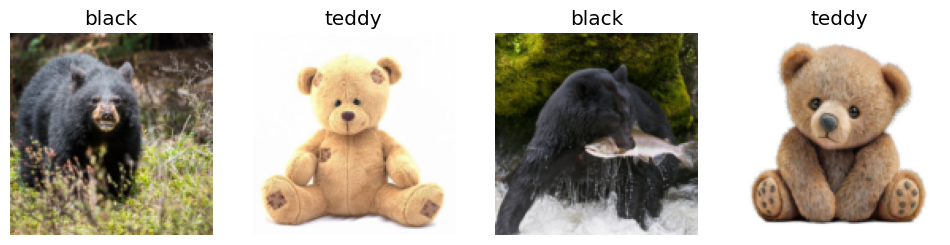

In [53]:
dls.valid.show_batch(max_n=4, nrows=1)

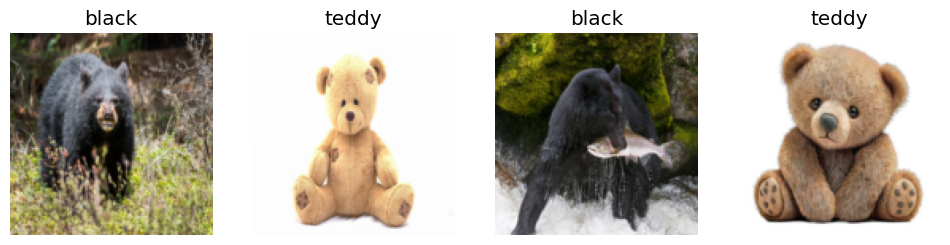

In [54]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

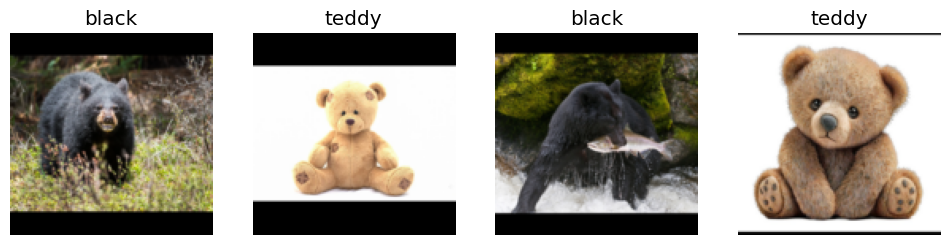

In [55]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

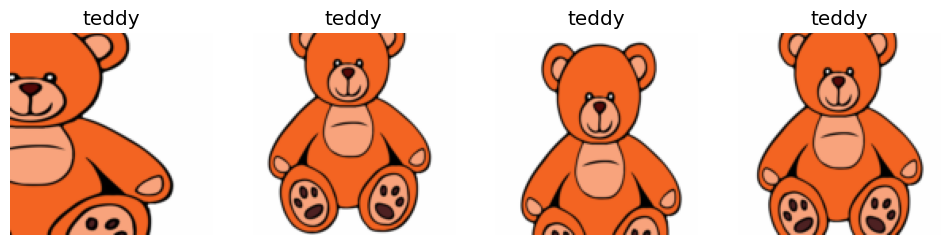

In [56]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

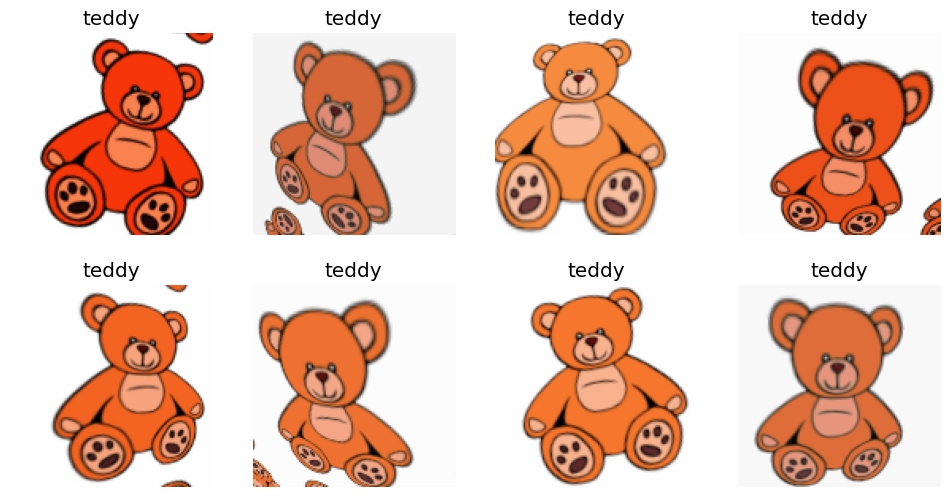

In [57]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [58]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [59]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.546770,0.291422,0.120000,00:20


/Users/AlexCorbin_1/anaconda3/envs/hcmle-env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.224724,0.150571,0.053333,00:15
1,0.171209,0.093144,0.026667,00:15
2,0.144539,0.075919,0.013333,00:14
3,0.119805,0.060753,0.013333,00:15


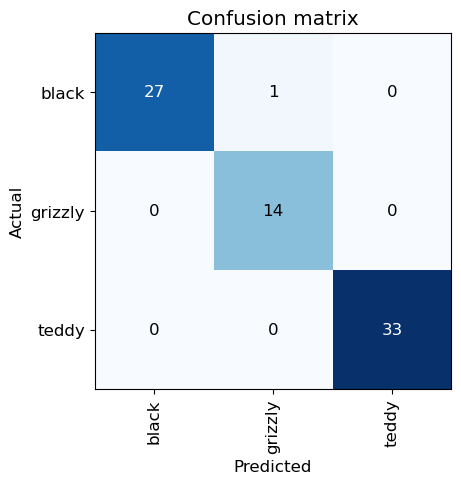

In [60]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

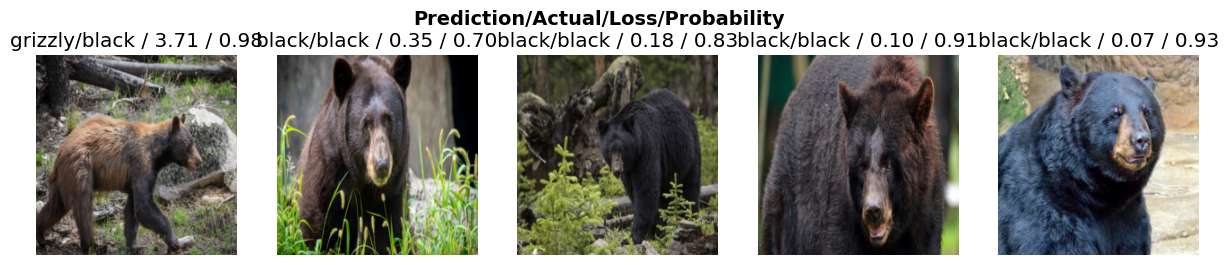

In [61]:
interp.plot_top_losses(5, nrows=1)

In [62]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/AlexCorbin_1/anaconda3/envs/hcmle-env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [72]:
learn.export()

In [73]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [74]:
learn_inf = load_learner(path/'export.pkl')

/Users/AlexCorbin_1/anaconda3/envs/hcmle-env/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [75]:
from fastai.vision.all import *
import random
import shutil

# Get all images in the folder
grizzly_imgs = get_image_files(Path('bears/grizzly'))

# Pick a random one
random_img = random.choice(grizzly_imgs)

# Copy it as 'grizzly.jpg' to the current directory
shutil.copy(random_img, Path('grizzly.jpg'))

print(f"Saved {random_img.name} as grizzly.jpg")

Saved e59665f8-4878-429c-a43f-72b9720136e7.jpg as grizzly.jpg


In [77]:
learn_inf.predict('grizzly.jpg')

('grizzly', tensor(1), tensor([2.0561e-04, 9.9947e-01, 3.2033e-04]))

In [78]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [63]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [68]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['grizzly.jpg'])

In [69]:
img = PILImage.create(btn_upload.data[-1])

In [70]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [79]:
pred,pred_idx,probs = learn_inf.predict(img)

In [80]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9999')

In [81]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

IndexError: list index out of range

In [82]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [83]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [84]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [87]:
from fastai.vision.all import *
import ipywidgets as widgets
from IPython.display import display

In [88]:
# Load exported model
learn_inf = load_learner('export.pkl')

# UI elements
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

# Classification handler
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

# Layout
display(VBox([
    widgets.Label('Select your bear!'),
    btn_upload, btn_run, out_pl, lbl_pred
]))

In [89]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 45.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 48.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [93]:
import gradio as gr
from fastai.vision.all import *

learn = load_learner('export.pkl')

def classify_image(img):
    pred, pred_idx, probs = learn.predict(img)
    return {learn.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}

gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(),
    title="Bear Classifier"
).launch()

/Users/AlexCorbin_1/anaconda3/envs/hcmle-env/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio/flagged/dataset1.csv


In [94]:
from pathlib import Path
import shutil

# Paths
bear_folder = Path('bears')
grizzly_img = Path('grizzly.jpg')

# Delete the bears folder and all its contents
if bear_folder.exists() and bear_folder.is_dir():
    shutil.rmtree(bear_folder)
    print("Deleted 'bears/' folder.")

# Delete grizzly.jpg
if grizzly_img.exists():
    grizzly_img.unlink()
    print("Deleted 'grizzly.jpg'")

Deleted 'bears/' folder.
Deleted 'grizzly.jpg'
